In [14]:
import pandas as pd

pest = (
    pd.read_csv("..\\EPest_county_estimates_2018.txt", sep="\t", na_values=["", " "])
      .assign(
          state_fips=lambda d: d["STATE_FIPS_CODE"].astype(str).str.zfill(2),
          county_fips=lambda d: d["COUNTY_FIPS_CODE"].astype(str).str.zfill(3),
      )
      .assign(fips=lambda d: d["state_fips"] + d["county_fips"])
      .drop(columns=["STATE_FIPS_CODE", "COUNTY_FIPS_CODE"])
)
pest.head()

,COMPOUND,YEAR,EPEST_LOW_KG,EPEST_HIGH_KG,state_fips,county_fips,fips
0,1-METHYL CYCLOPROPENE,2018,0.1,0.1,36,003,36003
1,1-METHYL CYCLOPROPENE,2018,NaN,0.1,36,007,36007
2,1-METHYL CYCLOPROPENE,2018,0.1,0.1,36,009,36009
3,1-METHYL CYCLOPROPENE,2018,NaN,0.1,36,011,36011
4,1-METHYL CYCLOPROPENE,2018,0.1,0.1,36,013,36013


In [15]:
import pandas as pd
import geopandas as gpd

# Read the CSV and convert to a GeoDataFrame
sites = (
    pd.read_csv("C:\\Users\\julia\\Downloads\\concat_garden_stats - concat_full.csv")  # Ensure correct path and filename
      .pipe(lambda d: gpd.GeoDataFrame(
          d,
          geometry=gpd.points_from_xy(d.decimalLongitude, d.decimalLatitude),
          crs="EPSG:4326"  # Set to WGS84
      ))
      .to_crs(counties.crs)  # Reproject to match the counties GeoDataFrame's CRS
)

sites = gpd.sjoin(
    sites,
    counties[["fips", "state_fips", "county_fips", "geometry"]],
    how="left",
    predicate="within"
)
sites.head()


,Sample,Homo,Het,Haploid.Cov,Error.Rate,Model.Fit,Genome.Size..b.,Genome.Size..Mb.,Label,Pop.x,...,proportion_natural_1000m,Unnamed: 49,Unnamed: 50,BIO4 = Temperature Seasonality (standard deviation ×100),Shannon idx,geometry,index_right,fips,state_fips,county_fips
0,342,97.8,2.16,13.1,0.00424,0.939,562115666.0,562.115666,Allentown_Ag_124_F_So,Allentown,...,92.284292,NaN,NaN,NaN,NaN,POINT (-89.48221 40.55407),982,17179,17,179
1,450,97.1,2.86,14.4,0.00322,0.724,538712096.0,538.712096,Knox_Nat_129_F_Co,Knox,...,19.613260,NaN,NaN,NaN,NaN,POINT (-86.74626 41.31733),460,18149,18,149
2,503,97.3,2.72,13.3,0.00492,0.989,524468355.0,524.468355,Mccombe_Ag_4_F_Wa,Mccombe,...,85.556170,NaN,NaN,NaN,NaN,POINT (-83.78944 41.0636),486,39063,39,063
3,556,97.6,2.39,16.5,0.00342,0.965,514089892.0,514.089892,Hernan_Ag_120_NA_Wa,Hernan,...,37.586493,NaN,NaN,NaN,NaN,POINT (-91.51231 38.63921),971,29073,29,073
4,4801,97.7,2.27,11.4,0.00286,0.794,535874656.0,535.874656,Hernan_Ag_86_M_Co,Hernan,...,37.586493,NaN,NaN,NaN,NaN,POINT (-91.51231 38.63921),971,29073,29,073


In [16]:
merged = sites.merge(pest, on="fips", how="left")


In [ ]:
import pandas as pd
import geopandas as gpd

SITE_PATH      = "C:\\Users\\julia\\Downloads\\concat_garden_stats - concat_full.csv"         # lat / lon columns
PEST_PATH      = "..\\EPest_county_estimates_2018.txt"     # tab-delimited USGS EPEST
COUNTY_SHP     = "..\\us_il_shapefiles\\cb_2018_us_county_5m.shp"   # TIGER/Line county boundaries
OUT_PATH       = "sites_with_pesticides.csv"

METRIC = "EPEST_HIGH_KG"  

wanted = [
    "GLYPHOSATE",
    "ATRAZINE",
    "2,4-D",
    "DICAMBA",
    "GLUFOSINATE",
    "METOLACHLOR",
]

counties = (
    gpd.read_file(COUNTY_SHP)
      .rename(columns={"GEOID": "fips"})
      [["fips", "geometry"]]
)

counties.head()


,fips,geometry
0,39071,"POLYGON ((-83.86976 39.05553, -83.86568 39.247..."
1,06003,"POLYGON ((-120.07248 38.50987, -120.07239 38.7..."
2,12033,"POLYGON ((-87.62999 30.87766, -87.62946 30.880..."
3,17101,"POLYGON ((-87.91028 38.57493, -87.90811 38.850..."
4,28153,"POLYGON ((-88.94317 31.78421, -88.94336 31.824..."


In [ ]:

sites = (
    pd.read_csv(SITE_PATH)
      .pipe(lambda d: gpd.GeoDataFrame(
          d, geometry=gpd.points_from_xy(d.decimalLongitude, d.decimalLatitude), crs="EPSG:4326"))
      .to_crs(counties.crs)                

sites = gpd.sjoin(sites, counties, how="left", predicate="within")

# keep only the original site columns (incl. fips we just added)
site_cols = [c for c in sites.columns if c not in ("index_right", "geometry")]


wanted_upper = [w.upper() for w in wanted]

pest = (
    pd.read_csv(PEST_PATH, sep="\t", na_values=["", " "])
      .assign(
          fips=lambda d: d["STATE_FIPS_CODE"].astype(str).str.zfill(2)
                        + d["COUNTY_FIPS_CODE"].astype(str).str.zfill(3),
          compound=lambda d: d["COMPOUND"].str.strip().str.upper(),
      )
      .query("compound in @wanted_upper")
      [["fips", "compound", METRIC]]
)

pest_wide = (
    pest.pivot_table(index="fips",
                     columns="compound",
                     values=METRIC,
                     aggfunc="first")   
      .reset_index()
      .rename_axis(columns=None)  
)

final = (
    sites[site_cols]         
      .merge(pest_wide, on="fips", how="left")
)

#reorder
pest_cols = [c for c in final.columns if c in wanted]
final = final[[c for c in final.columns if c not in pest_cols] + pest_cols]

final.to_csv(OUT_PATH, index=False)


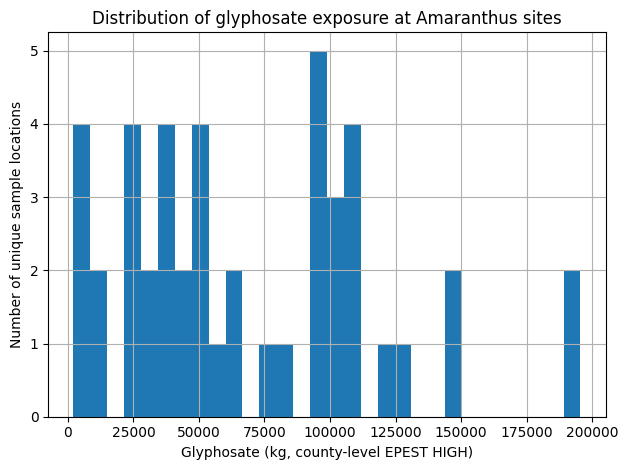

In [ ]:
import matplotlib.pyplot as plt
df = final.drop_duplicates(subset=['decimalLatitude', 'decimalLongitude'])

plt.figure()
(
    df['GLYPHOSATE']      
      .dropna()              
      .hist(bins=30)
)
plt.xlabel('Glyphosate (kg, county-level EPEST HIGH)')
plt.ylabel('Number of unique sample locations')
plt.title('Distribution of glyphosate exposure at Amaranthus sites')
plt.tight_layout()
plt.show()

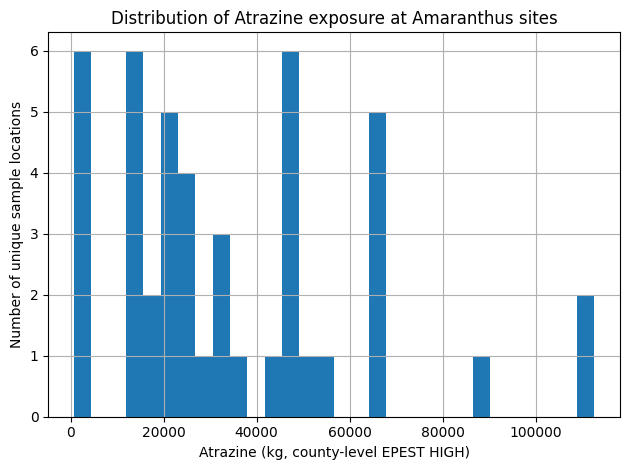

In [39]:
plt.figure()
(
    df['ATRAZINE']
      .dropna()               
      .hist(bins=30)
)
plt.xlabel('Atrazine (kg, county-level EPEST HIGH)')
plt.ylabel('Number of unique sample locations')
plt.title('Distribution of Atrazine exposure at Amaranthus sites')
plt.tight_layout()
plt.show()

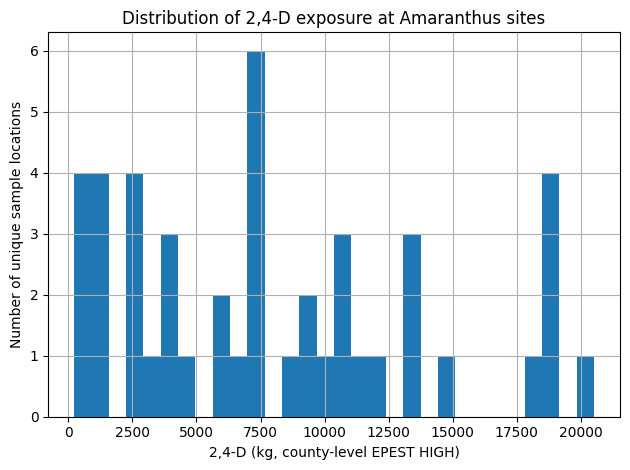

In [38]:
plt.figure()
(
    df['2,4-D']          # or whatever the column is named
      .dropna()               # ignore counties with no estimate
      .hist(bins=30)
)
plt.xlabel('2,4-D (kg, county-level EPEST HIGH)')
plt.ylabel('Number of unique sample locations')
plt.title('Distribution of 2,4-D exposure at Amaranthus sites')
plt.tight_layout()
plt.show()

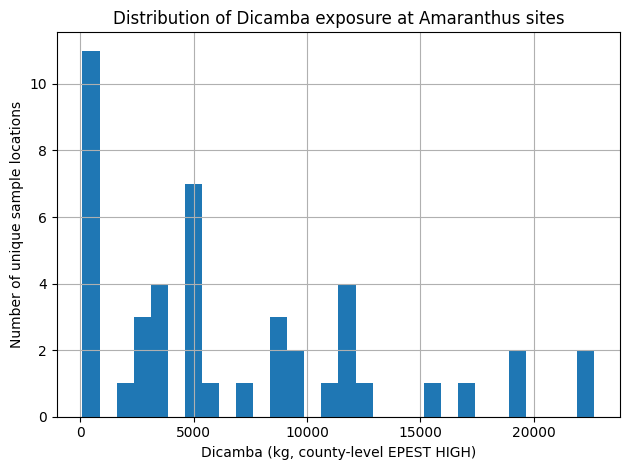

In [36]:
plt.figure()
(
    df['DICAMBA']
      .dropna()            
      .hist(bins=30)
)
plt.xlabel('Dicamba (kg, county-level EPEST HIGH)')
plt.ylabel('Number of unique sample locations')
plt.title('Distribution of Dicamba exposure at Amaranthus sites')
plt.tight_layout()
plt.show()

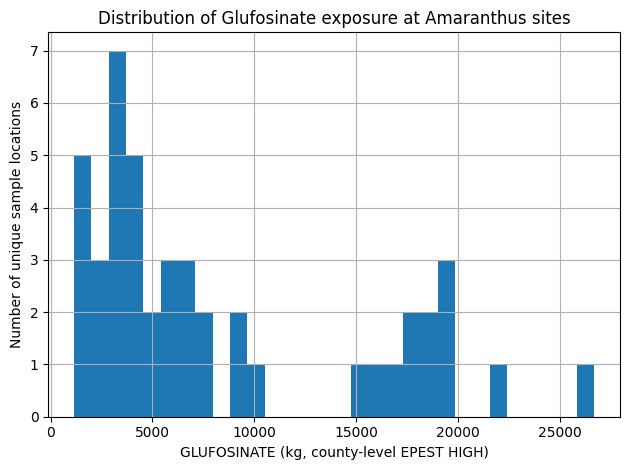

In [37]:
plt.figure()
(
    df['GLUFOSINATE']   
      .dropna()             
      .hist(bins=30)
)
plt.xlabel('GLUFOSINATE (kg, county-level EPEST HIGH)')
plt.ylabel('Number of unique sample locations')
plt.title('Distribution of Glufosinate exposure at Amaranthus sites')
plt.tight_layout()
plt.show()

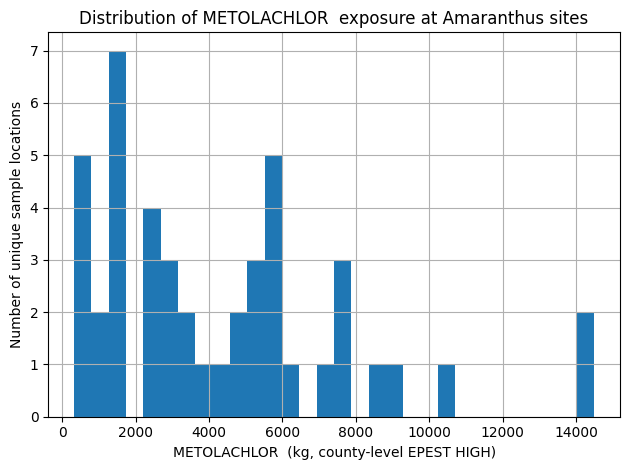

In [41]:
plt.figure()
(
    df['METOLACHLOR']   
      .dropna()             
      .hist(bins=30)
)
plt.xlabel('METOLACHLOR  (kg, county-level EPEST HIGH)')
plt.ylabel('Number of unique sample locations')
plt.title('Distribution of METOLACHLOR  exposure at Amaranthus sites')
plt.tight_layout()
plt.show()